# Dual Input Attention based LSTM model

In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import os

## Data Preparation

In [5]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

In [6]:
def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

In [7]:
max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

combined_df.head()

,time,cpu_temp,inlet_temp,it_power,fan_speed
0,4718,55.766525,22.468243,177.345436,3929.161963
1,4719,55.608490,22.468213,177.350546,3929.225715
2,4720,55.446706,22.468188,177.362315,3929.311931
3,4721,55.238044,22.468170,177.380743,3929.420613
4,4721,54.960208,22.468170,177.380743,3929.420613


In [8]:
df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

Shape of Final Dataframe = (4255, 5)


In [9]:
scalers = {
    'cpu_temp': MinMaxScaler(),
    'inlet_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    'fan_speed': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

In [69]:
df_scaled.head()

,cpu_temp,inlet_temp,it_power,fan_speed
0,0.671717,0.065816,0.671238,0.077869
1,0.666286,0.065810,0.671315,0.077907
2,0.660725,0.065806,0.671492,0.077959
3,0.653554,0.065802,0.671769,0.078024
4,0.644006,0.065802,0.671769,0.078024


## Model Definition

![Screenshot 2024-12-09 113553.png](<attachment:Screenshot 2024-12-09 113553.png>)
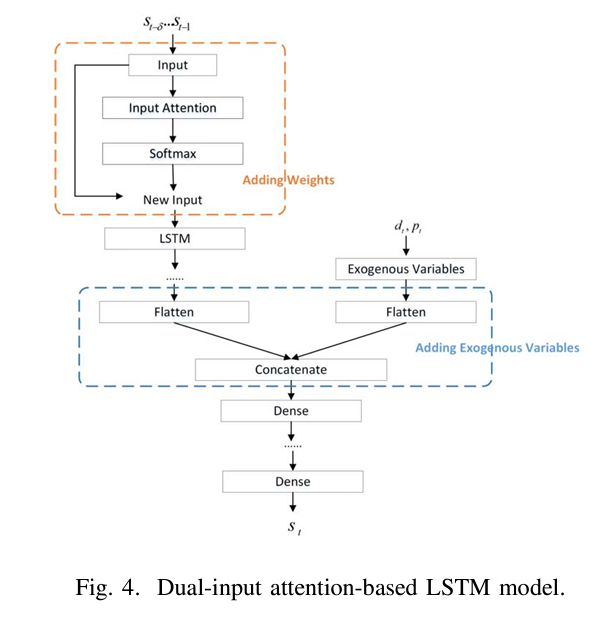

In [10]:
# class InputAttention(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, attention_size):
#         super(InputAttention, self).__init__()
        
#         self.query_layer = nn.Linear(input_size, attention_size)
#         self.key_layer = nn.Linear(input_size, attention_size)
#         self.value_layer = nn.Linear(input_size, attention_size)

#         self.lstm = nn.LSTM(input_size+attention_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def sdpa(self, query, key, value):
#         scores = torch.matmul(query, key.transpose(-2, -1))
#         scores = scores / np.sqrt(key.size(-1))
#         attention = F.softmax(scores, dim=-1)
#         context = torch.matmul(attention, value)
        
#         return context, attention
    
#     def forward(self, x):
#         query = self.query_layer(x)
#         key = self.key_layer(x)
#         value = self.value_layer(x)

#         context, attention = self.sdpa(query, key, value)
#         lstm_input = torch.cat([x, context], dim=-1)
#         h, c = self.lstm(lstm_input)
#         output = self.fc(h)

#         return output

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [45]:
class Seq2SeqNoAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, attention_size, output_length):
        super(Seq2SeqNoAttention, self).__init__()

        self.output_length = output_length
        
        # Encoder layers
        self.encoder_query_layer = nn.Linear(input_size, attention_size)
        self.encoder_key_layer = nn.Linear(input_size, attention_size)
        self.encoder_value_layer = nn.Linear(input_size, attention_size)
        self.encoder_lstm = nn.LSTM(input_size + attention_size, hidden_size, batch_first=True)

        # Decoder layers
        self.decoder_lstm = nn.LSTM(output_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def sdpa(self, query, key, value):
        """
        Scaled Dot-Product Attention.
        Args:
            query: [batch_size, seq_len, attention_size]
            key: [batch_size, seq_len, attention_size]
            value: [batch_size, seq_len, attention_size]
        Returns:
            context: [batch_size, seq_len, attention_size]
            attention: [batch_size, seq_len, seq_len]
        """
        scores = torch.matmul(query, key.transpose(-2, -1))  # [batch_size, seq_len, seq_len]
        scores = scores / torch.sqrt(torch.tensor(key.size(-1), dtype=torch.float32).to(key.device))
        attention = nn.functional.softmax(scores, dim=-1)  # [batch_size, seq_len, seq_len]
        context = torch.matmul(attention, value)  # [batch_size, seq_len, attention_size]
        return context, attention
        
    def encoder_forward(self, x):
        """
        Encoder forward pass.
        Args:
            x: Input tensor of shape [batch_size, seq_len, input_size]
        Returns:
            h: Hidden state from the LSTM [1, batch_size, hidden_size]
            c: Cell state from the LSTM [1, batch_size, hidden_size]
        """
        query = self.encoder_query_layer(x)  # [batch_size, seq_len, attention_size]
        key = self.encoder_key_layer(x)      # [batch_size, seq_len, attention_size]
        value = self.encoder_value_layer(x)  # [batch_size, seq_len, attention_size]

        context, attention = self.sdpa(query, key, value)  # Context: [batch_size, seq_len, attention_size]
        encoder_input = torch.cat([x, context], dim=-1)    # [batch_size, seq_len, input_size + attention_size]
        _, (h, c) = self.encoder_lstm(encoder_input)       # h, c: [1, batch_size, hidden_size]
        return h, c
    
    def decoder_forward(self, h, c):
        """
        Decoder forward pass without attention.
        Args:
            h: Hidden state from the encoder [1, batch_size, hidden_size]
            c: Cell state from the encoder [1, batch_size, hidden_size]
            target_length: Number of steps to decode
        Returns:
            outputs: [batch_size, target_length, output_size]
        """
        batch_size = h.size(1)
        decoder_input = torch.zeros(batch_size, 1, 1).to(h.device)  # Initial decoder input: [batch_size, 1, output_size]
        
        outputs = []
        hidden, cell = h, c
        for _ in range(self.output_length):
            lstm_out, (hidden, cell) = self.decoder_lstm(decoder_input, (hidden, cell))  # lstm_out: [batch_size, 1, hidden_size]
            output = self.fc(lstm_out)  # [batch_size, 1, output_size]
            outputs.append(output)
            decoder_input = output  # Use the current output as the next input

        outputs = torch.cat(outputs, dim=1)  # [batch_size, target_length, output_size]
        return outputs
    
    def forward(self, x):
        """
        Full forward pass of the Seq2Seq model.
        Args:
            x: Input tensor of shape [batch_size, seq_len, input_size]
            target_length: Number of steps to decode
        Returns:
            outputs: [batch_size, target_length, output_size]
        """
        h, c = self.encoder_forward(x)  # Encoder forward pass
        outputs = self.decoder_forward(h, c)  # Decoder forward pass
        return outputs


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

# Function to generate sample data
def generate_sample_data(num_samples, input_length, output_length, input_size, output_size):

    x = torch.sin(torch.linspace(0, 10, input_length)).unsqueeze(-1).repeat(num_samples, 1, input_size)
    y = torch.cos(torch.linspace(10, 20, output_length)).unsqueeze(-1).repeat(num_samples, 1, output_size)
    return x + torch.randn_like(x) * 0.1, y + torch.randn_like(y) * 0.1



# # Generate sample data
# x_train, y_train = generate_sample_data(500, input_length, output_length, input_size, output_size)
# x_test, y_test = generate_sample_data(100, input_length, output_length, input_size, output_size)

# print(x_train.shape, y_train.shape)

# # Create DataLoaders
# train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [47]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

df = df_scaled.copy()

# Parameters
input_size = 4
output_size = 1
hidden_size = 32                     # Hidden size of LSTM
attention_size = 16                   # Attention size
input_length = 40                    # Input sequence length
output_length = 10                    # Output sequence length
batch_size = 32                       # Batch size
num_epochs = 20                       # Number of training epochs
learning_rate = 0.001                 # Learning rate

# Create sequences
def create_sequences(df, input_length, output_length):
    x, y = [], []
    for i in range(len(df) - input_length - output_length + 1):
        # Input sequence
        x_seq = df.iloc[i : i + input_length, :input_size].values
        # Output sequence
        y_seq = df.iloc[i + input_length : i + input_length + output_length, 0].values
        x.append(x_seq)
        y.append(y_seq)
    return np.array(x), np.array(y)

# Generate input and output sequences
x, y = create_sequences(df_scaled, input_length, output_length)

# Convert to tensors
x_tensor = torch.tensor(x, dtype=torch.float32)  # Shape: [num_samples, input_length, input_size]
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Shape: [num_samples, output_length, output_size]

# Split into train and test sets
train_size = int(0.8 * len(x_tensor))
x_train, x_test = x_tensor[:train_size], x_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# Create DataLoaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print shapes
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")


x_train: torch.Size([3364, 40, 4]), y_train: torch.Size([3364, 10, 1])
x_test: torch.Size([842, 40, 4]), y_test: torch.Size([842, 10, 1])


In [48]:
# Initialize model, criterion, and optimizer
model = Seq2SeqNoAttention(input_size, hidden_size, output_size, attention_size, output_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(x_batch)
        
        # Compute loss
        loss = criterion(outputs, y_batch)
        train_loss += loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")


Epoch 1/20, Training Loss: 0.0782
Epoch 2/20, Training Loss: 0.0047
Epoch 3/20, Training Loss: 0.0032
Epoch 4/20, Training Loss: 0.0031
Epoch 5/20, Training Loss: 0.0030
Epoch 6/20, Training Loss: 0.0029
Epoch 7/20, Training Loss: 0.0028
Epoch 8/20, Training Loss: 0.0026
Epoch 9/20, Training Loss: 0.0028
Epoch 10/20, Training Loss: 0.0027
Epoch 11/20, Training Loss: 0.0026
Epoch 12/20, Training Loss: 0.0026
Epoch 13/20, Training Loss: 0.0027
Epoch 14/20, Training Loss: 0.0025
Epoch 15/20, Training Loss: 0.0026
Epoch 16/20, Training Loss: 0.0024
Epoch 17/20, Training Loss: 0.0026
Epoch 18/20, Training Loss: 0.0024
Epoch 19/20, Training Loss: 0.0025
Epoch 20/20, Training Loss: 0.0024


In [17]:
import time

In [ ]:

model.eval()
test_loss = 0.0
total_samples = 0
total_time = 0.0

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        start_time = time.time()  
        
        outputs = model(x_batch)
        
        end_time = time.time()  
        batch_time = end_time - start_time
        total_time += batch_time
        
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        total_samples += len(x_batch)

test_loss /= len(test_loader)

average_latency_per_sample = (total_time / total_samples) * 1000 

print(f"Test Loss: {test_loss:.4f}")
print(f"Average Latency Per Sample: {average_latency_per_sample:.2f} ms")


Test Loss: 0.0058
Average Latency Per Sample: 0.31 ms


In [56]:
def evaluate_model(model, dataloader, print_r2 = True, plot=True):
    # print("In evaluation function")
    model.eval()
    total_loss = 0
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            all_outputs.append(outputs.numpy())
            all_targets.append(y_batch.numpy())

    # print("Evaluation done")

    avg_loss = total_loss / len(dataloader)
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    all_outputs = np.column_stack([scalers['cpu_temp'].inverse_transform(all_outputs[:, i].reshape(-1, 1)).ravel() for i in range(all_outputs.shape[1])])
    all_targets = np.column_stack([scalers["cpu_temp"].inverse_transform(all_targets[:, i].reshape(-1, 1)).ravel() for i in range(all_targets.shape[1])])

    all_outputs = all_outputs.reshape(all_outputs.shape[0], -1)
    all_targets = all_targets.reshape(all_targets.shape[0], -1)

    # print(f"Evaluation Loss (MSE): {avg_loss:.4f}")
    mse_scores = []
    r2_scores = []

    for step in range(all_outputs.shape[1]):
        r2 = r2_score(all_targets[:, step], all_outputs[:, step])
        r2_scores.append(r2)
        if print_r2:
            print(f"R² Score for Horizon {step + 1}: {r2:.4f}")

    for step in range(all_outputs.shape[1]):
        mse = mean_squared_error(all_targets[:, step], all_outputs[:, step])
        mse_scores.append(mse)
        if print_r2:
            print(f"MSE for Horizon {step + 1}: {mse:.4f}")

    output_horizon = all_outputs.shape[1]
    if plot:
        fig, axes = plt.subplots(output_horizon, 1, figsize=(8, 25), sharex=True)
        
        for step in range(output_horizon):
            axes[step].plot(all_targets[:, step], label='Actual', color='blue')
            axes[step].plot(all_outputs[:, step], label='Predicted', color='red', linestyle='dashed')
            axes[step].set_title(f'Time Step {step + 1}: R2: {r2_scores[step]:.4f}, MSE: {mse_scores[step]:.4f}')
            axes[step].set_ylabel("CPU Temperature")
            if step == 0:
                axes[step].legend()

        plt.xlabel("Samples")
        plt.suptitle("Actual vs Predicted CPU Temperature for Each Step in Prediction Horizon")
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.show()

    return r2_scores, mse_scores

In evaluation function
Evaluation done
Evaluation Loss (MSE): 0.0045
R² Score for Horizon 1: 0.9699
R² Score for Horizon 2: 0.9666
R² Score for Horizon 3: 0.9623
R² Score for Horizon 4: 0.9582
R² Score for Horizon 5: 0.9539
R² Score for Horizon 6: 0.9497
R² Score for Horizon 7: 0.9456
R² Score for Horizon 8: 0.9418
R² Score for Horizon 9: 0.9383
R² Score for Horizon 10: 0.9350
MSE for Horizon 1: 2.3656
MSE for Horizon 2: 2.6362
MSE for Horizon 3: 2.9858
MSE for Horizon 4: 3.3255
MSE for Horizon 5: 3.6757
MSE for Horizon 6: 4.0259
MSE for Horizon 7: 4.3704
MSE for Horizon 8: 4.6968
MSE for Horizon 9: 5.0031
MSE for Horizon 10: 5.2909


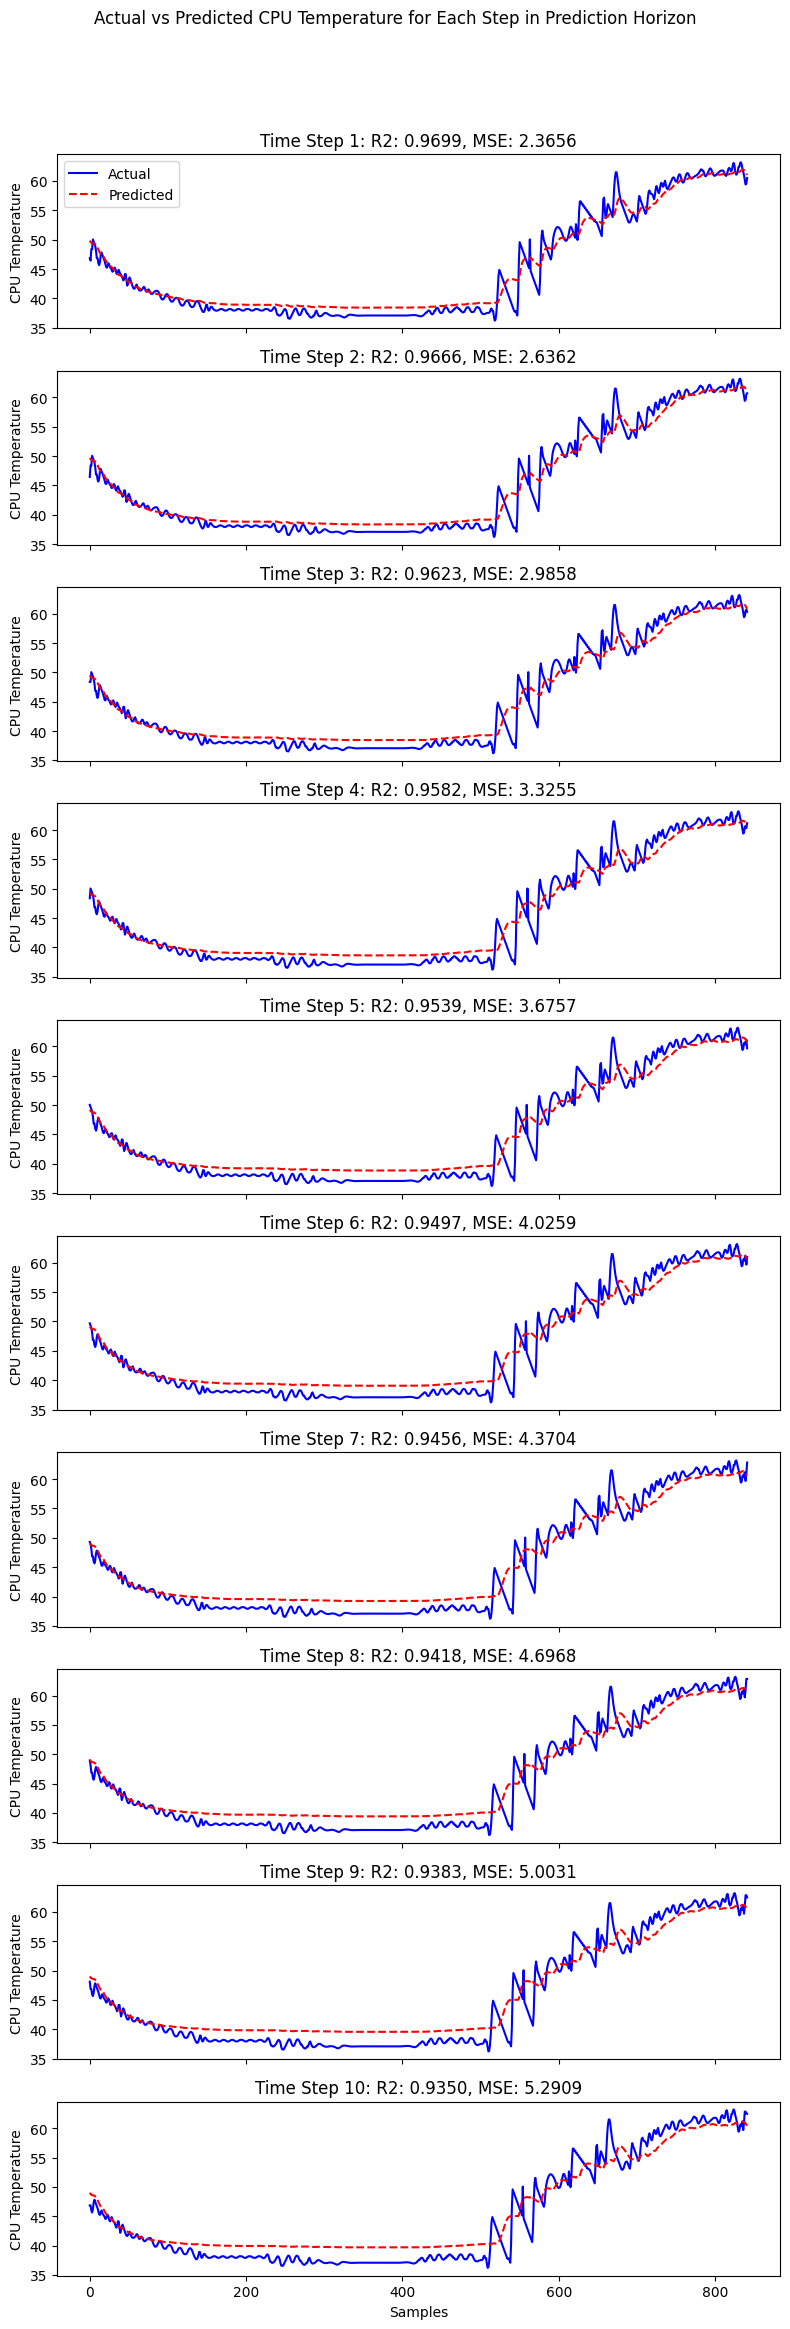

In [51]:
r2_scores, mse_scores = evaluate_model(model, test_loader)

In [52]:
# function to compare the performance of different models with different input lengths and same prediction horizon

def compare_models(input_length: int, output_length: int):

    # prepare the data

    x, y = create_sequences(df_scaled, input_length, output_length)

    x_tensor = torch.tensor(x, dtype=torch.float32)  
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1) 

    train_size = int(0.8 * len(x_tensor))
    x_train, x_test = x_tensor[:train_size], x_tensor[train_size:]
    y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # define the model

    model = Seq2SeqNoAttention(input_size, hidden_size, output_size, attention_size, output_length=output_length)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # train the model

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x_batch)
            
            # Compute loss
            loss = criterion(outputs, y_batch)
            train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        train_loss /= len(train_loader)
        # print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

    # evaluate the model
    r2, mse = [], []
    r2, mse = evaluate_model(model, test_loader, print_r2=False, plot=False)

    # return the r2 scores and mse scores

    return r2, mse

In [53]:
from tqdm import tqdm

In [ ]:
input_lengths = [i for i in range(5, 65, 5)]
output_length = 30

r2_scores = []
mse_scores = []

for input_length in tqdm(input_lengths, desc="Processing"):
    r2, mse = compare_models(input_length, output_length)
    r2_scores.append(r2)
    mse_scores.append(mse)

In [ ]:
fig, axes = plt.subplots(output_length, 2, figsize=(12, 6 * output_length), sharex=True)

for i in range(output_length):
    # Plot R² Score
    axes[i, 0].plot(input_lengths, [r2[i] for r2 in r2_scores], marker='o', label='R² Score')
    axes[i, 0].set_xlabel("Input Length")
    axes[i, 0].set_ylabel("R² Score")
    axes[i, 0].set_title(f"R² Score for Output {i + 1}")
    axes[i, 0].legend()

    # Plot MSE
    axes[i, 1].plot(input_lengths, [mse[i] for mse in mse_scores], marker='x', label='MSE', color='orange')
    axes[i, 1].set_xlabel("Input Length")
    axes[i, 1].set_ylabel("MSE")
    axes[i, 1].set_title(f"MSE for Output {i + 1}")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [47]:
for i in range(output_length):
    r2_i = [r2[i] for r2 in r2_scores]
    mse_i = [mse[i] for mse in mse_scores]

    best_r2 = max(r2_i)
    best_r2_idx = r2_i.index(best_r2)
    best_mse = min(mse_i)   
    best_mse_idx = mse_i.index(best_mse)

    print(f"Output {i + 1}: Best R² Score of {best_r2:.4f} with Input Length {input_lengths[best_r2_idx]}")

Output 1: Best R² Score of 0.9778 with Input Length 5
Output 2: Best R² Score of 0.9702 with Input Length 5
Output 3: Best R² Score of 0.9634 with Input Length 5
Output 4: Best R² Score of 0.9591 with Input Length 5
Output 5: Best R² Score of 0.9588 with Input Length 30
Output 6: Best R² Score of 0.9581 with Input Length 30
Output 7: Best R² Score of 0.9564 with Input Length 30
Output 8: Best R² Score of 0.9542 with Input Length 30
Output 9: Best R² Score of 0.9518 with Input Length 30
Output 10: Best R² Score of 0.9495 with Input Length 30
Output 11: Best R² Score of 0.9473 with Input Length 30
Output 12: Best R² Score of 0.9462 with Input Length 25
Output 13: Best R² Score of 0.9458 with Input Length 25
Output 14: Best R² Score of 0.9460 with Input Length 40
Output 15: Best R² Score of 0.9470 with Input Length 40
Output 16: Best R² Score of 0.9480 with Input Length 40
Output 17: Best R² Score of 0.9492 with Input Length 40
Output 18: Best R² Score of 0.9504 with Input Length 40
Outpu

In [62]:
# function to check the extent to which model performance is unaffected by the choice of input length

def check_model_stability(input_length: int, threshold_r2: float):
    """
    for a given input length, train the model with different
    output lengths until the r2 score falls below the threshold
    and store the maximum output length for which the r2 score
    is above the threshold.
    """
    
    output_length = 5
    max_length = 60
    while output_length <= max_length:
        r2, _ = compare_models(input_length, output_length)
        # print(len(r2))
        if r2[-1] < threshold_r2:
            break
        output_length += 2

    return output_length

In [63]:
results = {}
for input_length in range(5, 65, 5):
    output_length = check_model_stability(input_length, 0.95)
    results[input_length] = output_length
    print(f"Input Length: {input_length}, Maximum Stable Output Length: {output_length}")


Input Length: 5, Maximum Stable Output Length: 7
Input Length: 10, Maximum Stable Output Length: 9
Input Length: 15, Maximum Stable Output Length: 7
Input Length: 20, Maximum Stable Output Length: 11
Input Length: 25, Maximum Stable Output Length: 19
Input Length: 30, Maximum Stable Output Length: 11
Input Length: 35, Maximum Stable Output Length: 11
Input Length: 40, Maximum Stable Output Length: 9
Input Length: 45, Maximum Stable Output Length: 7
Input Length: 50, Maximum Stable Output Length: 9
Input Length: 55, Maximum Stable Output Length: 7
Input Length: 60, Maximum Stable Output Length: 9


In [64]:
results = {}
for input_length in range(5, 65, 5):
    output_length = check_model_stability(input_length, 0.90)
    results[input_length] = output_length
    print(f"Input Length: {input_length}, Maximum Stable Output Length: {output_length}")


Input Length: 5, Maximum Stable Output Length: 31
Input Length: 10, Maximum Stable Output Length: 37
Input Length: 15, Maximum Stable Output Length: 31
Input Length: 20, Maximum Stable Output Length: 37
Input Length: 25, Maximum Stable Output Length: 33
Input Length: 30, Maximum Stable Output Length: 49
Input Length: 35, Maximum Stable Output Length: 35
Input Length: 40, Maximum Stable Output Length: 29
Input Length: 45, Maximum Stable Output Length: 47
Input Length: 50, Maximum Stable Output Length: 21
Input Length: 55, Maximum Stable Output Length: 39
Input Length: 60, Maximum Stable Output Length: 43


In [65]:
# function to check the extent to which model performance is unaffected by the choice of input length

def check_model_stability_new(input_length: int, threshold_r2: float):
    """
    for a given input length, train the model with different
    output lengths until the r2 score falls below the threshold
    and store the maximum output length for which the r2 score
    is above the threshold.
    """
    
    output_length = 5
    max_length = 60
    while output_length <= max_length:
        r2, _ = compare_models(input_length, output_length)
        # print(len(r2))
        if r2[-1] < threshold_r2:
            break
        output_length += 5

    return output_length

In [66]:
results = {}
for input_length in range(5, 65, 5):
    output_length = check_model_stability_new(input_length, 0.85)
    results[input_length] = output_length
    print(f"Input Length: {input_length}, Maximum Stable Output Length: {output_length}")


Input Length: 5, Maximum Stable Output Length: 65


KeyboardInterrupt: 

In [23]:
input_size = 4
hidden_size = 64
output_size = 4
attention_size = 32
batch_size = 32
seq_len = 15
epochs = 100
learning_rate = 0.001

model = InputAttention(input_size, hidden_size, output_size, attention_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
forecast_horizon = 15

X, Y = [], []
for i in range(len(df_scaled) - seq_len - forecast_horizon + 1):
    X.append(df_scaled[i:i + seq_len])
    Y.append(df_scaled[i + seq_len:i + seq_len + forecast_horizon]) 

X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(Y_test, dtype=torch.float32)

print(f"X_train.shape = {X_train.shape}, Y_train.shape = {Y_train.shape}")
print(f"X_test.shape = {X_test.shape}, Y_test.shape = {Y_test.shape}")

X_train.shape = torch.Size([3380, 15, 4]), Y_train.shape = (3380, 15, 4)
X_test.shape = torch.Size([846, 15, 4]), Y_test.shape = (846, 15, 4)


In [11]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [24]:
def train_model(model, criterion, optimizer, seq_len, forecast_horizon, epochs=100):

    X, y = [], []
    for i in range(len(df_scaled) - seq_len - forecast_horizon + 1):
        X.append(df_scaled[i:i + seq_len])
        y.append(df_scaled[i + seq_len:i + seq_len + forecast_horizon]) 

    X = np.array(X)
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        train_loss = 0.0
        
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss}")
        
    return model, X_test, y_test

In [26]:
seq_len = 30
forecast_horizon = 30
model, X_test, y_test = train_model(model, criterion, optimizer, seq_len, forecast_horizon, epochs)

Epoch 1/100, Loss: 5.380929164588451
Epoch 2/100, Loss: 0.660807874519378
Epoch 3/100, Loss: 0.39944909047335386


KeyboardInterrupt: 

: 

In [12]:
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss}")

Epoch 1/100, Loss: 5.828096858225763
Epoch 2/100, Loss: 0.5585300393868238
Epoch 3/100, Loss: 0.2643698101164773
Epoch 4/100, Loss: 0.20211257750634104
Epoch 5/100, Loss: 0.17525750922504812
Epoch 6/100, Loss: 0.16208024276420474
Epoch 7/100, Loss: 0.1516418067039922
Epoch 8/100, Loss: 0.1456118756905198
Epoch 9/100, Loss: 0.14285212027607486
Epoch 10/100, Loss: 0.1365184435271658
Epoch 11/100, Loss: 0.13381558138644323
Epoch 12/100, Loss: 0.1319713417906314
Epoch 13/100, Loss: 0.1302267088321969
Epoch 14/100, Loss: 0.13046324189053848
Epoch 15/100, Loss: 0.1290985092637129
Epoch 16/100, Loss: 0.12709590699523687
Epoch 17/100, Loss: 0.1271202331990935
Epoch 18/100, Loss: 0.12851261551259086
Epoch 19/100, Loss: 0.12511026300489902
Epoch 20/100, Loss: 0.12133122986415401
Epoch 21/100, Loss: 0.12032650975743309
Epoch 22/100, Loss: 0.12030436558416113
Epoch 23/100, Loss: 0.12060650822240859
Epoch 24/100, Loss: 0.11854835133999586
Epoch 25/100, Loss: 0.11973549303365871
Epoch 26/100, Loss: 

In [19]:
import time

model.eval()
with torch.no_grad():
    start_time = time.time()
    outputs = model(X_test)
    end_time = time.time()
    val_loss = criterion(outputs, y_test)
    print(f"Validation Loss: {val_loss}")

latency = (end_time - start_time)/len(X_test)
print(f"Time taken for inference: {latency} seconds")

Validation Loss: 0.007102558854967356
Time taken for inference: 5.6152929932794954e-05 seconds


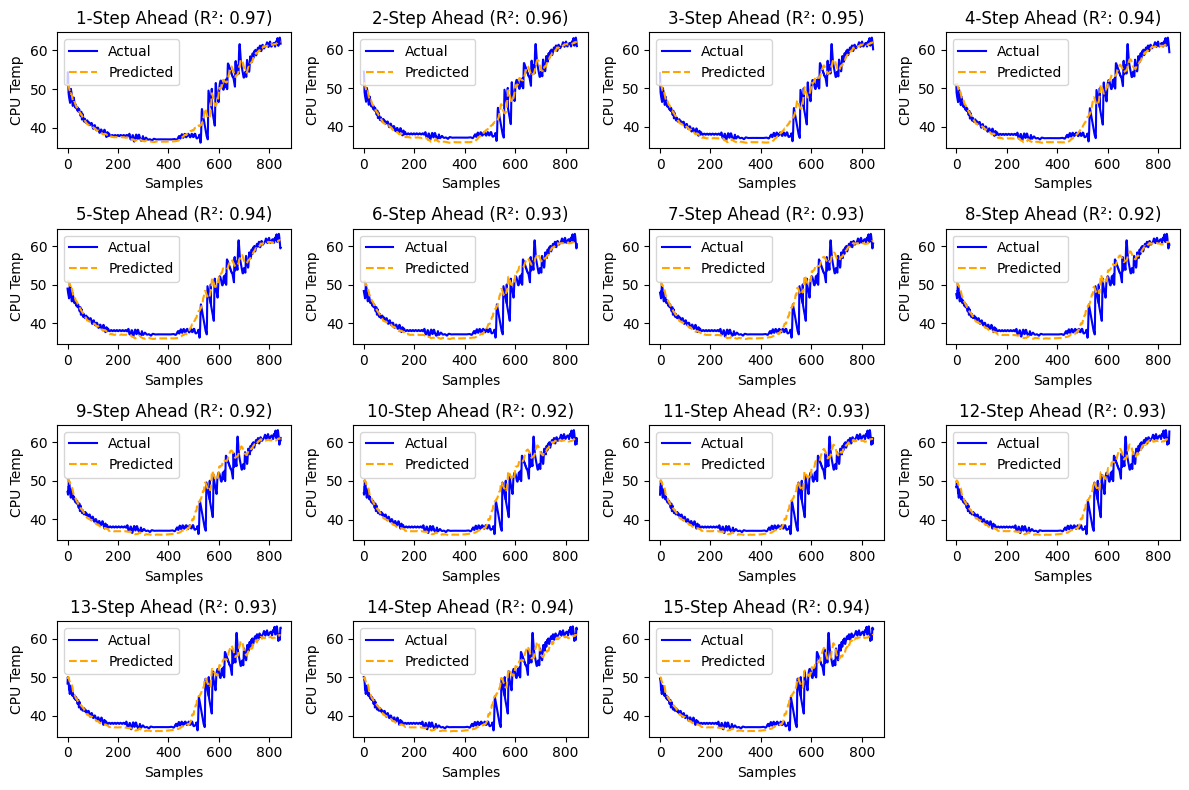

In [14]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

steps = X_test.shape[1]  
cpu_temp_index = 0       
r2_scores = []
rmse_scores = []

model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()  
    actuals = y_test.numpy()

plt.figure(figsize=(12, 8))
cpu_temp_scaler = scalers['cpu_temp']  

for t in range(steps):
    t_predictions = predictions[:, t, [cpu_temp_index]]  
    t_actuals = actuals[:, t, [cpu_temp_index]]          

    t_predictions = cpu_temp_scaler.inverse_transform(t_predictions)
    t_actuals = cpu_temp_scaler.inverse_transform(t_actuals)

    r2 = r2_score(t_actuals, t_predictions)
    r2_scores.append(r2)

    rmse = np.sqrt(((t_predictions - t_actuals) ** 2).mean())
    rmse_scores.append(rmse)

    plt.subplot(4, (steps + 3) // 4, t + 1) 
    plt.plot(t_actuals, label="Actual", color="blue")
    plt.plot(t_predictions, label="Predicted", color="orange", linestyle="dashed")
    plt.title(f"{t + 1}-Step Ahead (R²: {r2:.2f})")
    plt.xlabel("Samples")
    plt.ylabel("CPU Temp")
    plt.legend()

plt.tight_layout()
plt.show()

In [15]:
print("R² Scores at Each Step:")
for t, r2 in enumerate(r2_scores, start=1):
    print(f"{t}-Step Ahead: R² = {r2:.4f}")

print("\nRMSE Scores at Each Step:")
for t, rmse in enumerate(rmse_scores, start=1):
    print(f"{t}-Step Ahead: RMSE = {rmse:.4f}")

R² Scores at Each Step:
1-Step Ahead: R² = 0.9669
2-Step Ahead: R² = 0.9578
3-Step Ahead: R² = 0.9509
4-Step Ahead: R² = 0.9434
5-Step Ahead: R² = 0.9359
6-Step Ahead: R² = 0.9298
7-Step Ahead: R² = 0.9257
8-Step Ahead: R² = 0.9234
9-Step Ahead: R² = 0.9229
10-Step Ahead: R² = 0.9238
11-Step Ahead: R² = 0.9261
12-Step Ahead: R² = 0.9293
13-Step Ahead: R² = 0.9326
14-Step Ahead: R² = 0.9358
15-Step Ahead: R² = 0.9383

RMSE Scores at Each Step:
1-Step Ahead: RMSE = 1.5992
2-Step Ahead: RMSE = 1.8091
3-Step Ahead: RMSE = 1.9525
4-Step Ahead: RMSE = 2.0981
5-Step Ahead: RMSE = 2.2367
6-Step Ahead: RMSE = 2.3437
7-Step Ahead: RMSE = 2.4161
8-Step Ahead: RMSE = 2.4573
9-Step Ahead: RMSE = 2.4708
10-Step Ahead: RMSE = 2.4598
11-Step Ahead: RMSE = 2.4272
12-Step Ahead: RMSE = 2.3796
13-Step Ahead: RMSE = 2.3277
14-Step Ahead: RMSE = 2.2774
15-Step Ahead: RMSE = 2.2380


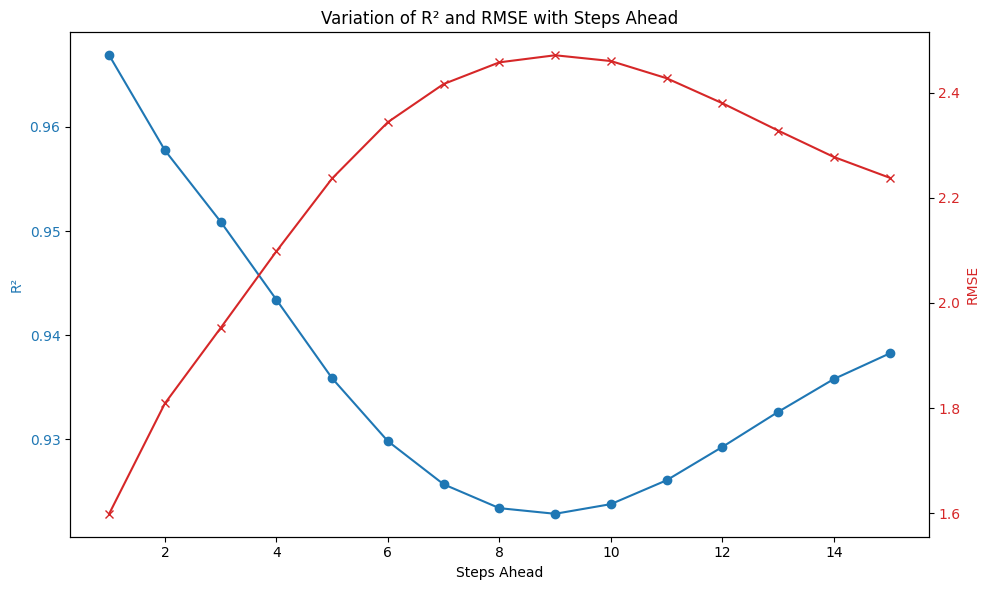

In [16]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Steps Ahead')
ax1.set_ylabel('R²', color='tab:blue')
ax1.plot(range(1, steps + 1), r2_scores, color='tab:blue', label='R²', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('RMSE', color='tab:red')
ax2.plot(range(1, steps + 1), rmse_scores, color='tab:red', label='RMSE', marker='x')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Variation of R² and RMSE with Steps Ahead')
fig.tight_layout()
plt.show()